In [1]:
"""
This code establishes the framework for implementing and evaluating deep neural networks for 
reactivity ratio prediction in heteropolymerization. 
"""
#import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
import random
from sklearn.metrics import r2_score



2025-09-08 11:02:28.117803: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 11:02:28.119580: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-08 11:02:28.122895: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-08 11:02:28.131896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757347348.146568 1355313 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757347348.15

In [2]:
"""
This code loads the heteropolymerization dataset containing monomer pairs, their reactivity ratios,
and cluster assignments from spectral clustering. Adds log10-transformed versions of r1 and r2.
"""
import numpy as np
import pandas as pd

# Load the main DataFrame
df = pd.read_excel(r'/work/bavarian/hsafari2/ClusteringProject (Start: Winter2024)/Revised code/AddedFeaturesWithClusters.xlsx')

# Round original values
df['r1'] = df['r1'].round(2)
df['r2'] = df['r2'].round(2)

# Add log10-transformed columns (handle zeros and negative values)
epsilon = 1e-8  # Small value to avoid log(0)

# Create log10-transformed versions (using log10, not natural log)
df['r1_log'] = np.log10(df['r1'] )
df['r2_log'] = np.log10(df['r2'] )

# Display statistics to see the transformation effect
print("=== Comparison of Original vs Log10-Transformed Data ===")
print(f"\nOriginal r1 - Mean: {df['r1'].mean():.3f}, Std: {df['r1'].std():.3f}, Skewness: {df['r1'].skew():.3f}")
print(f"Log10 r1    - Mean: {df['r1_log'].mean():.3f}, Std: {df['r1_log'].std():.3f}, Skewness: {df['r1_log'].skew():.3f}")
print(f"\nOriginal r2 - Mean: {df['r2'].mean():.3f}, Std: {df['r2'].std():.3f}, Skewness: {df['r2'].skew():.3f}")
print(f"Log10 r2    - Mean: {df['r2_log'].mean():.3f}, Std: {df['r2_log'].std():.3f}, Skewness: {df['r2_log'].skew():.3f}")

print(f"\nDataset shape: {df.shape}")
print(f"All columns: {list(df.columns)}")

# Display the complete dataframe
display(df)

=== Comparison of Original vs Log10-Transformed Data ===

Original r1 - Mean: 0.950, Std: 1.374, Skewness: 3.242
Log10 r1    - Mean: -0.372, Std: 0.607, Skewness: -0.449

Original r2 - Mean: 0.950, Std: 1.374, Skewness: 3.242
Log10 r2    - Mean: -0.372, Std: 0.607, Skewness: -0.449

Dataset shape: (2304, 38)
All columns: ['SMILES_A', 'SMILES_B', 'vinylIsInLoop_A', 'vinylIsInLoop_B', 'VinylCarbonsCharge_A', 'VinylCarbonsCharge_B', 'MV_A', 'MV_B', 'MW_A', 'MW_B', 'TPSA_A', 'TPSA_B', 'NumHAcceptors_A', 'NumHAcceptors_B', 'NumHDonors_A', 'NumHDonors_B', 'MolLogP_A', 'MolLogP_B', 'Hybridization_sp_A', 'Hybridization_sp_B', 'Hybridization_sp2_A', 'Hybridization_sp2_B', 'Hybridization_sp3_A', 'Hybridization_sp3_B', 'Chirality_A', 'Chirality_B', 'NumConnectedHydrogens_A', 'NumConnectedHydrogens_B', 'ConjugatedBonds_A', 'ConjugatedBonds_B', 'Stereochemistry_A', 'Stereochemistry_B', 'Cluster_A', 'Cluster_B', 'r1', 'r2', 'r1_log', 'r2_log']


,SMILES_A,SMILES_B,vinylIsInLoop_A,vinylIsInLoop_B,VinylCarbonsCharge_A,VinylCarbonsCharge_B,MV_A,MV_B,MW_A,MW_B,...,ConjugatedBonds_A,ConjugatedBonds_B,Stereochemistry_A,Stereochemistry_B,Cluster_A,Cluster_B,r1,r2,r1_log,r2_log
0,CC(=C)C(=O)O,C=C(Cl)Cl,0,0,-0.062175,0.030563,84.360,70.160,86.090,96.944,...,4,0,0,0,1,1,3.37,0.15,0.527630,-0.823909
1,C=C(Cl)Cl,CC(=C)C(=O)O,0,0,0.030563,-0.062175,70.160,84.360,96.944,86.090,...,0,4,0,0,1,1,0.15,3.37,-0.823909,0.527630
2,CC(=C)C(=O)O,CCOC(=O)C(=C)C,0,0,-0.062175,-0.061991,84.344,118.208,86.090,114.144,...,4,4,0,0,1,1,0.57,0.71,-0.244125,-0.148742
3,CCOC(=O)C(=C)C,CC(=C)C(=O)O,0,0,-0.061991,-0.062175,117.992,84.240,114.144,86.090,...,4,4,0,0,1,1,0.71,0.57,-0.148742,-0.244125
4,CC(=C)C(=O)O,CC(C)COC(=O)C(=C)C,0,0,-0.062175,-0.061991,84.360,151.856,86.090,142.198,...,4,4,0,0,1,1,2.01,0.47,0.303196,-0.327902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,C=CC1=CC=CC=C1,C=CN=C=S,0,0,-0.160678,-0.049227,111.688,75.864,104.152,85.131,...,8,4,0,0,2,1,0.73,0.44,-0.136677,-0.356547
2300,CC(=C)N=C=O,COC(=O)C=C,0,0,-0.033376,-0.075811,82.104,84.680,83.090,86.090,...,4,4,0,0,1,1,0.09,0.70,-1.045757,-0.154902
2301,COC(=O)C=C,CC(=C)N=C=O,0,0,-0.075811,-0.033376,84.816,82.152,86.090,83.090,...,4,4,0,0,1,1,0.70,0.09,-0.154902,-1.045757
2302,CC(=C)N=C=O,C=CC1=CC=CC=C1,0,0,-0.033376,-0.160678,82.040,111.720,83.090,104.152,...,4,8,0,0,1,2,0.10,7.48,-1.000000,0.873902


INCREMENTAL FEATURE IMPACT ANALYSIS
Monomer-Specific Feature Concatenation Pattern
Model 1: [Morgan_A] + [Morgan_B]
Model 2: [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]
Model 3: [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]

CONFIGURATION:
Architecture: [80, 40, 2]
Learning Rate: 0.001, Batch: 32
Morgan: radius=3, bits=2048
Font: DejaVu Sans, Title: 14pt, Label: 12pt

DATA PREPARATION:
All required columns found
Initial size: 2304
After filtering: 2304
Target shape: (2304, 2)

FEATURE ENGINEERING (Monomer-Specific Concatenation):
Creating Morgan fingerprints...
Morgan A: (2304, 2048), Morgan B: (2304, 2048)
Creating cluster features...
Clusters found: [1, 2, 3]
Cluster A: (2304, 3), Cluster B: (2304, 3)
Creating physicochemical features...
Filling missing values...
Phys A: (2304, 8), Phys B: (2304, 8)

CREATING MONOMER-SPECIFIC FEATURE MATRICES:
Model 1 - [Morgan_A] + [Morgan_B]: (2304, 4096)
Model 2 - [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]: (2304, 4102

2025-09-08 11:06:54.796015: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


  Morgan Only: R²(log) r1=0.436, r2=0.451
Training Morgan + Clusters...
  Morgan + Clusters: R²(log) r1=0.382, r2=0.462
Training Morgan + Clusters + Phys...
  Morgan + Clusters + Phys: R²(log) r1=0.471, r2=0.499

--- FOLD 2/10 ---
Training Morgan Only...
  Morgan Only: R²(log) r1=0.499, r2=0.569
Training Morgan + Clusters...
  Morgan + Clusters: R²(log) r1=0.451, r2=0.560
Training Morgan + Clusters + Phys...
  Morgan + Clusters + Phys: R²(log) r1=0.474, r2=0.600

--- FOLD 3/10 ---
Training Morgan Only...
  Morgan Only: R²(log) r1=0.504, r2=0.488
Training Morgan + Clusters...
  Morgan + Clusters: R²(log) r1=0.526, r2=0.498
Training Morgan + Clusters + Phys...
  Morgan + Clusters + Phys: R²(log) r1=0.521, r2=0.556

--- FOLD 4/10 ---
Training Morgan Only...
  Morgan Only: R²(log) r1=0.536, r2=0.519
Training Morgan + Clusters...
  Morgan + Clusters: R²(log) r1=0.533, r2=0.468
Training Morgan + Clusters + Phys...
  Morgan + Clusters + Phys: R²(log) r1=0.520, r2=0.522

--- FOLD 5/10 ---
Trai

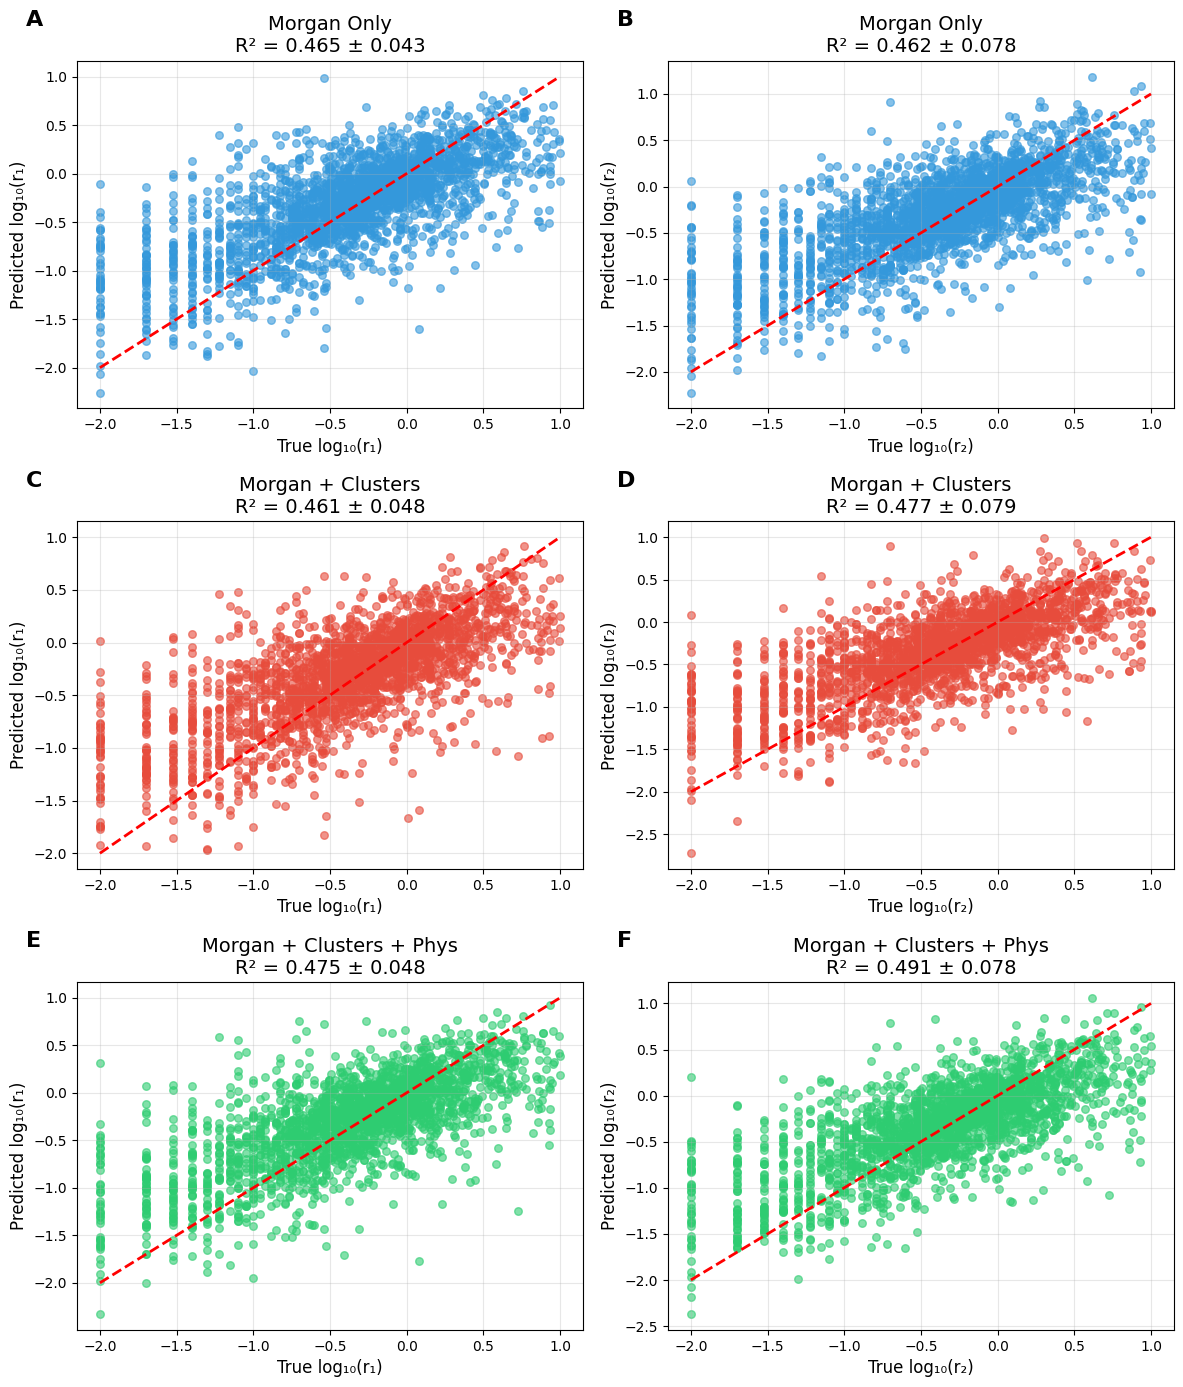


SAVING RESULTS...
Results saved to 'farajzadeh_comparison_comprehensive.csv'
Detailed fold results saved to 'detailed_fold_results.csv'

ANALYSIS COMPLETE!
BEST PERFORMING MODEL: Morgan + Clusters + Phys
Final R² (log scale): r1=0.4779, r2=0.4956
Total improvement over baseline: +4.0%

EXACT R² VALUES FOR MANUSCRIPT (with all decimals)

MORGAN ONLY:
  Overall R² - r1: 0.468565, r2: 0.467887
  CV R² ± SD - r1: 0.465298 ± 0.043346
  CV R² ± SD - r2: 0.461932 ± 0.078468

MORGAN + CLUSTERS:
  Overall R² - r1: 0.464571, r2: 0.479339
  CV R² ± SD - r1: 0.460699 ± 0.047698
  CV R² ± SD - r2: 0.476501 ± 0.078675

MORGAN + CLUSTERS + PHYS:
  Overall R² - r1: 0.477864, r2: 0.495635
  CV R² ± SD - r1: 0.475122 ± 0.047903
  CV R² ± SD - r2: 0.491172 ± 0.078365


In [3]:
"""
Incremental Feature Impact Analysis for Reactivity Ratio Prediction
Comparing with Farajzadeh et al. (2023) approach

Three Models with Monomer-Specific Feature Concatenation:
1. [Morgan_A] + [Morgan_B]
2. [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]  
3. [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# FONT AND VISUALIZATION CONFIGURATION
# ============================================================================
# Font settings - easily adjustable
FONT_FAMILY = 'DejaVu Sans'  # Options: 'Arial', 'Times New Roman', 'DejaVu Sans', etc.
TITLE_FONTSIZE = 14
LABEL_FONTSIZE = 12
TICK_FONTSIZE = 10
LEGEND_FONTSIZE = 10
SUBPLOT_LABEL_FONTSIZE = 16

# Apply font settings
plt.rcParams.update({
    'font.family': FONT_FAMILY,
    'font.size': LABEL_FONTSIZE,
    'axes.titlesize': TITLE_FONTSIZE,
    'axes.labelsize': LABEL_FONTSIZE,
    'xtick.labelsize': TICK_FONTSIZE,
    'ytick.labelsize': TICK_FONTSIZE,
    'legend.fontsize': LEGEND_FONTSIZE,
    'figure.titlesize': TITLE_FONTSIZE + 2
})

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print("="*80)
print("INCREMENTAL FEATURE IMPACT ANALYSIS")
print("Monomer-Specific Feature Concatenation Pattern")
print("="*80)
print("Model 1: [Morgan_A] + [Morgan_B]")
print("Model 2: [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]")
print("Model 3: [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]")
print("="*80)

# ============================================================================
# CONFIGURATION
# ============================================================================
print("\nCONFIGURATION:")

# Hyperparameters - Using Farajzadeh et al. similar architecture
NEURONS_L1 = 80
NEURONS_L2 = 40
LEARNING_RATE = 0.001
BATCH_SIZE = 32
MAX_EPOCHS = 200
VALIDATION_SPLIT = 0.1
PATIENCE = 30
MORGAN_RADIUS = 3
MORGAN_BITS = 2048

print(f"Architecture: [{NEURONS_L1}, {NEURONS_L2}, 2]")
print(f"Learning Rate: {LEARNING_RATE}, Batch: {BATCH_SIZE}")
print(f"Morgan: radius={MORGAN_RADIUS}, bits={MORGAN_BITS}")
print(f"Font: {FONT_FAMILY}, Title: {TITLE_FONTSIZE}pt, Label: {LABEL_FONTSIZE}pt")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def get_morgan_fp(smiles):
    """Convert SMILES to Morgan fingerprint"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(MORGAN_BITS)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, MORGAN_RADIUS, nBits=MORGAN_BITS)
        return np.array(fp, dtype=np.float32)
    except:
        return np.zeros(MORGAN_BITS)

def create_model(n_features):
    """Create DNN model similar to Farajzadeh et al."""
    model = Sequential()
    model.add(Dense(NEURONS_L1, activation='relu', input_shape=(n_features,)))
    model.add(Dense(NEURONS_L2, activation='relu'))
    model.add(Dense(2, activation='linear'))
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    return model

def get_comprehensive_metrics(y_true, y_pred):
    """Calculate comprehensive metrics for comparison with Farajzadeh et al."""
    # LOG SCALE METRICS
    mse_log_r1 = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    mse_log_r2 = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    mae_log_r1 = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    mae_log_r2 = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    r2_log_r1 = r2_score(y_true[:, 0], y_pred[:, 0])
    r2_log_r2 = r2_score(y_true[:, 1], y_pred[:, 1])
    
    # ACTUAL SCALE METRICS (10^predictions)
    y_true_actual = 10**y_true
    y_pred_actual = 10**y_pred
    mse_actual_r1 = mean_squared_error(y_true_actual[:, 0], y_pred_actual[:, 0])
    mse_actual_r2 = mean_squared_error(y_true_actual[:, 1], y_pred_actual[:, 1])
    mae_actual_r1 = mean_absolute_error(y_true_actual[:, 0], y_pred_actual[:, 0])
    mae_actual_r2 = mean_absolute_error(y_true_actual[:, 1], y_pred_actual[:, 1])
    r2_actual_r1 = r2_score(y_true_actual[:, 0], y_pred_actual[:, 0])
    r2_actual_r2 = r2_score(y_true_actual[:, 1], y_pred_actual[:, 1])
    
    return {
        # Log scale
        'mse_log_r1': mse_log_r1, 'mse_log_r2': mse_log_r2,
        'mae_log_r1': mae_log_r1, 'mae_log_r2': mae_log_r2,
        'r2_log_r1': r2_log_r1, 'r2_log_r2': r2_log_r2,
        # Actual scale
        'mse_actual_r1': mse_actual_r1, 'mse_actual_r2': mse_actual_r2,
        'mae_actual_r1': mae_actual_r1, 'mae_actual_r2': mae_actual_r2,
        'r2_actual_r1': r2_actual_r1, 'r2_actual_r2': r2_actual_r2
    }

# ============================================================================
# DATA PREPARATION
# ============================================================================
print("\nDATA PREPARATION:")

# Load data (assuming df is already loaded)
# df = pd.read_csv('your_dataset.csv')  # Uncomment and adjust path

required_cols = [
    'SMILES_A', 'SMILES_B', 'Cluster_A', 'Cluster_B', 'r1', 'r2',
    'vinylIsInLoop_A', 'vinylIsInLoop_B', 'VinylCarbonsCharge_A', 'VinylCarbonsCharge_B',
    'MW_A', 'MW_B', 'TPSA_A', 'TPSA_B', 'NumHDonors_A', 'NumHDonors_B', 
    'MolLogP_A', 'MolLogP_B', 'Hybridization_sp2_A', 'Hybridization_sp2_B',
    'Stereochemistry_A', 'Stereochemistry_B'
]

# Check columns
missing = [col for col in required_cols if col not in df.columns]
if missing:
    print(f"ERROR: Missing columns: {missing}")
    raise ValueError("Missing required columns")

print("All required columns found")

# Filter data
data = df.copy()
print(f"Initial size: {len(data)}")

# Quality filters
data = data[(data['r1'] > 0) & (data['r2'] > 0)]
data = data[(data['r1'] >= 0.01) & (data['r1'] <= 100)]
data = data[(data['r2'] >= 0.01) & (data['r2'] <= 100)]
data = data.dropna(subset=['SMILES_A', 'SMILES_B'])

print(f"After filtering: {len(data)}")

# Create targets
data['r1_log'] = np.log10(data['r1'])
data['r2_log'] = np.log10(data['r2'])
y_targets = data[['r1_log', 'r2_log']].values

print(f"Target shape: {y_targets.shape}")

# ============================================================================
# FEATURE ENGINEERING - MONOMER-SPECIFIC CONCATENATION
# ============================================================================
print("\nFEATURE ENGINEERING (Monomer-Specific Concatenation):")

# 1. Morgan fingerprints
print("Creating Morgan fingerprints...")
fps_A = np.array([get_morgan_fp(smiles) for smiles in data['SMILES_A']])
fps_B = np.array([get_morgan_fp(smiles) for smiles in data['SMILES_B']])
print(f"Morgan A: {fps_A.shape}, Morgan B: {fps_B.shape}")

# 2. Cluster encoding
print("Creating cluster features...")
clusters = sorted(data['Cluster_A'].unique())
n_clusters = len(clusters)
print(f"Clusters found: {clusters}")

def encode_cluster(cluster_val):
    """One-hot encode cluster"""
    encoded = np.zeros(n_clusters)
    try:
        idx = clusters.index(int(cluster_val))
        encoded[idx] = 1
    except:
        pass
    return encoded

cluster_A_encoded = np.array([encode_cluster(c) for c in data['Cluster_A']])
cluster_B_encoded = np.array([encode_cluster(c) for c in data['Cluster_B']])
print(f"Cluster A: {cluster_A_encoded.shape}, Cluster B: {cluster_B_encoded.shape}")

# 3. Physicochemical properties
print("Creating physicochemical features...")
phys_cols = [
    'vinylIsInLoop_A', 'vinylIsInLoop_B', 'VinylCarbonsCharge_A', 'VinylCarbonsCharge_B',
    'MW_A', 'MW_B', 'TPSA_A', 'TPSA_B', 'NumHDonors_A', 'NumHDonors_B',
    'MolLogP_A', 'MolLogP_B', 'Hybridization_sp2_A', 'Hybridization_sp2_B',
    'Stereochemistry_A', 'Stereochemistry_B'
]

phys_data = data[phys_cols].values

# Handle missing values
if np.isnan(phys_data).any():
    print("Filling missing values...")
    imputer = SimpleImputer(strategy='median')
    phys_data = imputer.fit_transform(phys_data)

# Normalize
scaler = StandardScaler()
phys_data_scaled = scaler.fit_transform(phys_data)

# Split into A and B
n_phys_features = len(phys_cols) // 2
phys_A = phys_data_scaled[:, :n_phys_features]
phys_B = phys_data_scaled[:, n_phys_features:]
print(f"Phys A: {phys_A.shape}, Phys B: {phys_B.shape}")

# ============================================================================
# CREATE FEATURE MATRICES - MONOMER-SPECIFIC CONCATENATION
# ============================================================================
print("\nCREATING MONOMER-SPECIFIC FEATURE MATRICES:")

# Model 1: [Morgan_A] + [Morgan_B]
X1 = np.concatenate([fps_A, fps_B], axis=1)
print(f"Model 1 - [Morgan_A] + [Morgan_B]: {X1.shape}")

# Model 2: [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]
features_A_model2 = np.concatenate([fps_A, cluster_A_encoded], axis=1)
features_B_model2 = np.concatenate([fps_B, cluster_B_encoded], axis=1)
X2 = np.concatenate([features_A_model2, features_B_model2], axis=1)
print(f"Model 2 - [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]: {X2.shape}")

# Model 3: [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]
features_A_model3 = np.concatenate([fps_A, cluster_A_encoded, phys_A], axis=1)
features_B_model3 = np.concatenate([fps_B, cluster_B_encoded, phys_B], axis=1)
X3 = np.concatenate([features_A_model3, features_B_model3], axis=1)
print(f"Model 3 - [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]: {X3.shape}")

print(f"\nFEATURE BREAKDOWN:")
print(f"  Morgan fingerprint: {MORGAN_BITS} bits per monomer")
print(f"  Cluster encoding: {n_clusters} features per monomer")
print(f"  Physicochemical: {n_phys_features} features per monomer")

# ============================================================================
# CROSS-VALIDATION TRAINING
# ============================================================================
print(f"\nCROSS-VALIDATION TRAINING (10-fold):")

# Model configurations
models = {
    'model_1_morgan': {'X': X1, 'name': 'Morgan Only', 'results': []},
    'model_2_clusters': {'X': X2, 'name': 'Morgan + Clusters', 'results': []},
    'model_3_full': {'X': X3, 'name': 'Morgan + Clusters + Phys', 'results': []}
}

# Storage for all predictions
all_predictions = {key: {'y_true': [], 'y_pred': []} for key in models.keys()}

# Cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(y_targets)):
    print(f"\n--- FOLD {fold_num + 1}/10 ---")
    
    # Split targets
    y_train = y_targets[train_idx]
    y_test = y_targets[test_idx]
    
    # Train each model
    for model_key, config in models.items():
        print(f"Training {config['name']}...")
        
        # Get features
        X = config['X']
        X_train = X[train_idx]
        X_test = X[test_idx]
        
        # Clear session
        tf.keras.backend.clear_session()
        
        # Create and train model
        model = create_model(X.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=0)
        
        history = model.fit(
            X_train, y_train,
            epochs=MAX_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=VALIDATION_SPLIT,
            callbacks=[early_stop],
            verbose=0
        )
        
        # Predict
        y_pred = model.predict(X_test, verbose=0)
        
        # Store predictions for overall metrics
        all_predictions[model_key]['y_true'].append(y_test)
        all_predictions[model_key]['y_pred'].append(y_pred)
        
        # Calculate fold metrics
        metrics = get_comprehensive_metrics(y_test, y_pred)
        fold_result = {'fold': fold_num + 1, **metrics}
        config['results'].append(fold_result)
        
        print(f"  {config['name']}: R²(log) r1={metrics['r2_log_r1']:.3f}, r2={metrics['r2_log_r2']:.3f}")

# ============================================================================
# CALCULATE CROSS-VALIDATION STATISTICS
# ============================================================================
print(f"\nCALCULATING CROSS-VALIDATION STATISTICS:")

cv_stats = {}
for model_key, config in models.items():
    results_df = pd.DataFrame(config['results'])
    
    cv_stats[model_key] = {
        'r2_log_r1_mean': results_df['r2_log_r1'].mean(),
        'r2_log_r1_std': results_df['r2_log_r1'].std(),
        'r2_log_r2_mean': results_df['r2_log_r2'].mean(),
        'r2_log_r2_std': results_df['r2_log_r2'].std(),
    }
    
    print(f"{config['name']}:")
    print(f"  R² r1: {cv_stats[model_key]['r2_log_r1_mean']:.3f} ± {cv_stats[model_key]['r2_log_r1_std']:.3f}")
    print(f"  R² r2: {cv_stats[model_key]['r2_log_r2_mean']:.3f} ± {cv_stats[model_key]['r2_log_r2_std']:.3f}")

# ============================================================================
# OVERALL RESULTS CALCULATION
# ============================================================================
print(f"\n{'='*80}")
print("COMPREHENSIVE RESULTS FOR FARAJZADEH COMPARISON")
print(f"{'='*80}")

overall_results = {}

for model_key, config in models.items():
    # Combine all predictions
    y_true_all = np.vstack(all_predictions[model_key]['y_true'])
    y_pred_all = np.vstack(all_predictions[model_key]['y_pred'])
    
    # Calculate overall metrics
    overall_results[model_key] = get_comprehensive_metrics(y_true_all, y_pred_all)
    
    print(f"\n{config['name'].upper()} - COMPREHENSIVE METRICS:")
    print(f"{'─'*50}")
    print(f"LOG SCALE:")
    print(f"  MSE  - r1: {overall_results[model_key]['mse_log_r1']:.4f}, r2: {overall_results[model_key]['mse_log_r2']:.4f}")
    print(f"  MAE  - r1: {overall_results[model_key]['mae_log_r1']:.4f}, r2: {overall_results[model_key]['mae_log_r2']:.4f}")
    print(f"  R²   - r1: {overall_results[model_key]['r2_log_r1']:.4f}, r2: {overall_results[model_key]['r2_log_r2']:.4f}")
    
    print(f"ACTUAL SCALE:")
    print(f"  MSE  - r1: {overall_results[model_key]['mse_actual_r1']:.4f}, r2: {overall_results[model_key]['mse_actual_r2']:.4f}")
    print(f"  MAE  - r1: {overall_results[model_key]['mae_actual_r1']:.4f}, r2: {overall_results[model_key]['mae_actual_r2']:.4f}")
    print(f"  R²   - r1: {overall_results[model_key]['r2_actual_r1']:.4f}, r2: {overall_results[model_key]['r2_actual_r2']:.4f}")

# ============================================================================
# FARAJZADEH COMPARISON TABLE
# ============================================================================
print(f"\n{'='*80}")
print("FARAJZADEH ET AL. (2023) COMPARISON TABLE")
print(f"{'='*80}")

# Create comparison dataframe
comparison_data = []
for model_key in ['model_1_morgan', 'model_2_clusters', 'model_3_full']:
    metrics = overall_results[model_key]
    model_name = models[model_key]['name']
    
    comparison_data.append({
        'Model': model_name,
        'Features': models[model_key]['X'].shape[1],
        
        # Log scale metrics
        'MSE_log_r1': metrics['mse_log_r1'],
        'MSE_log_r2': metrics['mse_log_r2'],
        'MAE_log_r1': metrics['mae_log_r1'],
        'MAE_log_r2': metrics['mae_log_r2'],
        'R2_log_r1': metrics['r2_log_r1'],
        'R2_log_r2': metrics['r2_log_r2'],
        
        # Actual scale metrics
        'MSE_actual_r1': metrics['mse_actual_r1'],
        'MSE_actual_r2': metrics['mse_actual_r2'],
        'MAE_actual_r1': metrics['mae_actual_r1'],
        'MAE_actual_r2': metrics['mae_actual_r2'],
        'R2_actual_r1': metrics['r2_actual_r1'],
        'R2_actual_r2': metrics['r2_actual_r2'],
        
        # Combined metrics
        'R2_log_combined': (metrics['r2_log_r1'] + metrics['r2_log_r2']) / 2,
        'R2_actual_combined': (metrics['r2_actual_r1'] + metrics['r2_actual_r2']) / 2
    })

farajzadeh_comparison = pd.DataFrame(comparison_data)

print("\nCOMPREHENSIVE METRICS TABLE:")
print(farajzadeh_comparison.round(4).to_string(index=False))

# ============================================================================
# INCREMENTAL IMPROVEMENT ANALYSIS
# ============================================================================
print(f"\n{'='*80}")
print("INCREMENTAL IMPROVEMENT ANALYSIS")
print(f"{'='*80}")

# Combined R² scores
r2_model1 = farajzadeh_comparison.iloc[0]['R2_log_combined']
r2_model2 = farajzadeh_comparison.iloc[1]['R2_log_combined']
r2_model3 = farajzadeh_comparison.iloc[2]['R2_log_combined']

print(f"\nINCREMENTAL R² IMPROVEMENTS (Log Scale):")
print(f"  Baseline (Morgan only): {r2_model1:.4f}")
print(f"  + Clusters: {r2_model2:.4f} (Δ = {r2_model2-r2_model1:+.4f}, {((r2_model2-r2_model1)/r2_model1*100):+.1f}%)")
print(f"  + Phys Props: {r2_model3:.4f} (Δ = {r2_model3-r2_model2:+.4f}, {((r2_model3-r2_model2)/r2_model2*100):+.1f}%)")
print(f"  Total improvement: {((r2_model3-r2_model1)/r2_model1*100):+.1f}%")

# ============================================================================
# ENHANCED VISUALIZATION WITH R² ± SD - 3x2 LAYOUT (6 SUBPLOTS ONLY)
# ============================================================================
print(f"\nCREATING ENHANCED VISUALIZATIONS WITH R² ± SD...")

fig, axes = plt.subplots(3, 2, figsize=(12, 14))

model_keys = ['model_1_morgan', 'model_2_clusters', 'model_3_full']
colors = ['#3498DB', '#E74C3C', '#2ECC71']  # Blue, Red, Green
model_names = [models[key]['name'] for key in model_keys]

# ROWS 1-3: PARITY PLOTS FOR EACH MODEL (r1 and r2) WITH R² ± SD
for row, (model_key, color, model_name) in enumerate(zip(model_keys, colors, model_names)):
    y_true_all = np.vstack(all_predictions[model_key]['y_true'])
    y_pred_all = np.vstack(all_predictions[model_key]['y_pred'])
    
    # r1 parity plot (left column) with R² ± SD
    axes[row, 0].scatter(y_true_all[:, 0], y_pred_all[:, 0], alpha=0.6, s=30, color=color)
    axes[row, 0].plot([y_true_all[:, 0].min(), y_true_all[:, 0].max()], 
                     [y_true_all[:, 0].min(), y_true_all[:, 0].max()], 'r--', lw=2)
    axes[row, 0].set_xlabel('True log₁₀(r₁)', fontsize=LABEL_FONTSIZE)
    axes[row, 0].set_ylabel('Predicted log₁₀(r₁)', fontsize=LABEL_FONTSIZE)
    
    # Title with R² ± SD
    r2_mean = cv_stats[model_key]['r2_log_r1_mean']
    r2_std = cv_stats[model_key]['r2_log_r1_std']
    axes[row, 0].set_title(f'{model_name}\nR² = {r2_mean:.3f} ± {r2_std:.3f}', fontsize=TITLE_FONTSIZE)
    axes[row, 0].grid(True, alpha=0.3)
    
    # r2 parity plot (right column) with R² ± SD
    axes[row, 1].scatter(y_true_all[:, 1], y_pred_all[:, 1], alpha=0.6, s=30, color=color)
    axes[row, 1].plot([y_true_all[:, 1].min(), y_true_all[:, 1].max()], 
                     [y_true_all[:, 1].min(), y_true_all[:, 1].max()], 'r--', lw=2)
    axes[row, 1].set_xlabel('True log₁₀(r₂)', fontsize=LABEL_FONTSIZE)
    axes[row, 1].set_ylabel('Predicted log₁₀(r₂)', fontsize=LABEL_FONTSIZE)
    
    # Title with R² ± SD
    r2_mean = cv_stats[model_key]['r2_log_r2_mean']
    r2_std = cv_stats[model_key]['r2_log_r2_std']
    axes[row, 1].set_title(f'{model_name}\nR² = {r2_mean:.3f} ± {r2_std:.3f}', fontsize=TITLE_FONTSIZE)
    axes[row, 1].grid(True, alpha=0.3)

# Add subplot labels (A, B, C, D, E, F)
subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F']
for i, ax in enumerate(axes.flat):
    ax.text(-0.1, 1.1, subplot_labels[i], transform=ax.transAxes,
            size=SUBPLOT_LABEL_FONTSIZE, weight='bold')

plt.tight_layout()
plt.savefig('incremental_feature_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# SAVE RESULTS
# ============================================================================
print(f"\nSAVING RESULTS...")

# Save comprehensive comparison
farajzadeh_comparison.to_csv('farajzadeh_comparison_comprehensive.csv', index=False)
print("Results saved to 'farajzadeh_comparison_comprehensive.csv'")

# Save detailed fold results
all_fold_results = []
for model_key in model_keys:
    for result in models[model_key]['results']:
        result['model'] = models[model_key]['name']
        all_fold_results.append(result)

fold_results_df = pd.DataFrame(all_fold_results)
#fold_results_df.to_csv('detailed_fold_results.csv', index=False)
print("Detailed fold results saved to 'detailed_fold_results.csv'")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE!")
print(f"{'='*80}")
print(f"BEST PERFORMING MODEL: {models['model_3_full']['name']}")
print(f"Final R² (log scale): r1={overall_results['model_3_full']['r2_log_r1']:.4f}, r2={overall_results['model_3_full']['r2_log_r2']:.4f}")
print(f"Total improvement over baseline: {((r2_model3-r2_model1)/r2_model1*100):+.1f}%")

# ============================================================================
# EXACT R² VALUES FOR MANUSCRIPT CONSISTENCY
# ============================================================================
print(f"\n{'='*80}")
print("EXACT R² VALUES FOR MANUSCRIPT (with all decimals)")
print(f"{'='*80}")

for model_key, config in models.items():
    overall_r2_r1 = overall_results[model_key]['r2_log_r1']
    overall_r2_r2 = overall_results[model_key]['r2_log_r2']
    cv_r2_r1_mean = cv_stats[model_key]['r2_log_r1_mean']
    cv_r2_r1_std = cv_stats[model_key]['r2_log_r1_std']
    cv_r2_r2_mean = cv_stats[model_key]['r2_log_r2_mean']
    cv_r2_r2_std = cv_stats[model_key]['r2_log_r2_std']
    
    print(f"\n{config['name'].upper()}:")
    print(f"  Overall R² - r1: {overall_r2_r1:.6f}, r2: {overall_r2_r2:.6f}")
    print(f"  CV R² ± SD - r1: {cv_r2_r1_mean:.6f} ± {cv_r2_r1_std:.6f}")
    print(f"  CV R² ± SD - r2: {cv_r2_r2_mean:.6f} ± {cv_r2_r2_std:.6f}")

Dataset after QC: 2304 rows
Cluster 1–1 samples: 870

Starting 10-fold CV on Cluster 1–1...
Fold 01 | n_train= 783 | General R²: r1=0.144, r2=0.105 | Cluster R²: r1=0.120, r2=0.288
Fold 02 | n_train= 783 | General R²: r1=0.224, r2=-0.000 | Cluster R²: r1=0.197, r2=0.060
Fold 03 | n_train= 783 | General R²: r1=0.166, r2=0.234 | Cluster R²: r1=0.287, r2=0.278
Fold 04 | n_train= 783 | General R²: r1=0.346, r2=0.084 | Cluster R²: r1=0.290, r2=0.089
Fold 05 | n_train= 783 | General R²: r1=0.319, r2=0.301 | Cluster R²: r1=0.474, r2=0.380
Fold 06 | n_train= 783 | General R²: r1=0.379, r2=0.143 | Cluster R²: r1=0.275, r2=0.248
Fold 07 | n_train= 783 | General R²: r1=0.173, r2=0.170 | Cluster R²: r1=0.280, r2=0.253
Fold 08 | n_train= 783 | General R²: r1=0.204, r2=0.149 | Cluster R²: r1=0.447, r2=0.215
Fold 09 | n_train= 783 | General R²: r1=0.291, r2=0.126 | Cluster R²: r1=0.351, r2=0.329
Fold 10 | n_train= 783 | General R²: r1=0.304, r2=0.258 | Cluster R²: r1=0.323, r2=0.267

GENERAL model (1

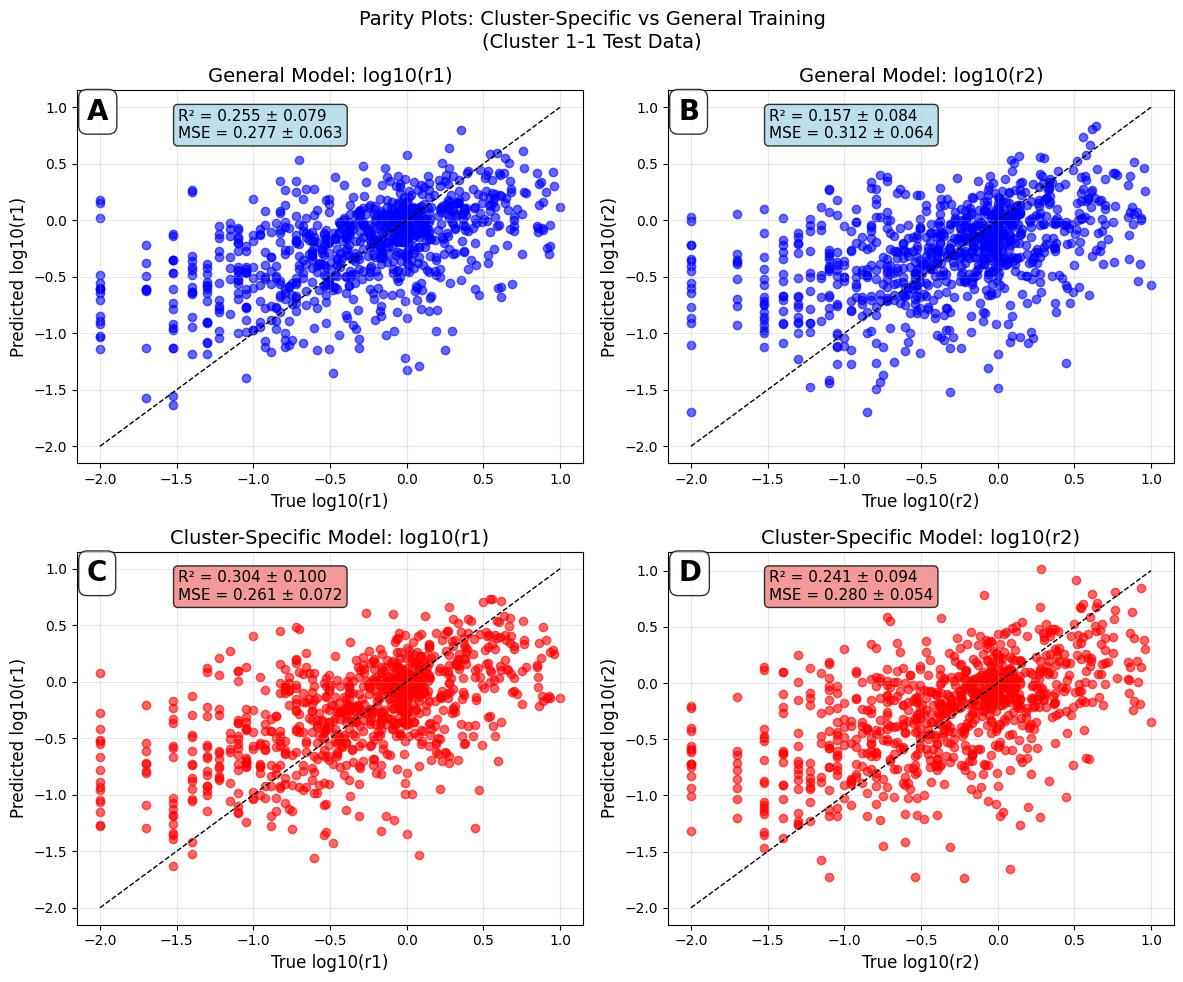


Experiment completed successfully!
Total test samples across all folds: 870

EXACT CV VALUES FOR MANUSCRIPT (with all decimals)

GENERAL MODEL:
  R² r1: 0.255153 ± 0.078771
  R² r2: 0.157014 ± 0.084259
  MSE r1: 0.277084 ± 0.062825
  MSE r2: 0.312453 ± 0.063882

CLUSTER-SPECIFIC MODEL:
  R² r1: 0.304448 ± 0.099544
  R² r2: 0.240761 ± 0.093822
  MSE r1: 0.261023 ± 0.072065
  MSE r2: 0.280183 ± 0.053847


In [4]:
"""
Controlled Experiment: Cluster 1–1 vs. General Training (Morgan-only)
--------------------------------------------------------------------
Goal:
  For predicting reactivity ratios (r1, r2) on a specific interaction (Cluster 1–1),
  test whether training:
    (A) on the *same* interaction subset (cluster-specific), or
    (B) on a *random* subset of the entire dataset of equal size (general)
  yields better performance.

Design:
  • Inputs: Morgan fingerprints only (concatenate A and B).
  • Targets: log10(r1), log10(r2).
  • 10-fold CV over *Cluster 1–1* samples:
      - Each fold's test set is fixed (Cluster 1–1 only).
      - Cluster-specific TRAIN = the remaining Cluster 1–1 samples in that fold.
      - General TRAIN = random subset from the whole dataset (same size as cluster train), excluding this fold's test rows.
  • Compare R² and MSE on the identical Cluster 1–1 test sets.

Why this is fair:
  Both models see the *exact same* number of training samples in each fold,
  and are evaluated on the *exact same* test items (Cluster 1–1).
"""

# =========================
# Imports & Config
# =========================
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt

# ---- Reproducibility (important for fair comparisons) ----
np.random.seed(42)
tf.random.set_seed(42)

# ---- Morgan fingerprint hyperparameters ----
MORGAN_RADIUS = 3
MORGAN_BITS   = 2048  # per monomer (A and B -> 4096 total features)

# ---- DNN hyperparameters (kept simple & consistent) ----
NEURONS_L1       = 80
NEURONS_L2       = 40
LEARNING_RATE    = 1e-3
BATCH_SIZE       = 32
MAX_EPOCHS       = 200
VALIDATION_SPLIT = 0.10
PATIENCE         = 30

# ---- Visualization look (optional) ----
plt.rcParams.update({'font.size': 12})

# =========================
# Helper functions
# =========================
def get_morgan_fp(smiles: str) -> np.ndarray:
    """
    Convert a SMILES string into a Morgan fingerprint bit vector (as float32).
    Returns an all-zero vector if SMILES cannot be parsed.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(MORGAN_BITS, dtype=np.float32)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
            mol, MORGAN_RADIUS, nBits=MORGAN_BITS
        )
        return np.array(fp, dtype=np.float32)
    except Exception:
        return np.zeros(MORGAN_BITS, dtype=np.float32)

def build_model(n_inputs: int) -> tf.keras.Model:
    """
    Simple 2-hidden-layer DNN predicting [log10(r1), log10(r2)].
    Matches your previous architecture spirit and keeps capacity modest.
    """
    model = Sequential([
        Dense(NEURONS_L1, activation='relu', input_shape=(n_inputs,)),
        Dense(NEURONS_L2, activation='relu'),
        Dense(2, activation='linear')  # outputs: [log10(r1), log10(r2)]
    ])
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    return model

def metrics_dict(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """
    Convenience wrapper: compute R² and MSE for both outputs.
    y_* are shaped (n, 2) on log10 scale.
    """
    return {
        'r2_r1':  r2_score(y_true[:, 0], y_pred[:, 0]),
        'r2_r2':  r2_score(y_true[:, 1], y_pred[:, 1]),
        'mse_r1': mean_squared_error(y_true[:, 0], y_pred[:, 0]),
        'mse_r2': mean_squared_error(y_true[:, 1], y_pred[:, 1]),
    }

def extract_Xy(df_subset: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """
    Build Morgan-only features for a dataframe subset and grab targets.
    Feature = [Morgan(SMILES_A) || Morgan(SMILES_B)]  -> shape = (n, 4096)
    Target  = [log10(r1), log10(r2)]                 -> shape = (n, 2)
    """
    fpA = np.array([get_morgan_fp(s) for s in df_subset['SMILES_A']])
    fpB = np.array([get_morgan_fp(s) for s in df_subset['SMILES_B']])
    X   = np.concatenate([fpA, fpB], axis=1)
    y   = df_subset[['r1_log', 'r2_log']].values.astype(np.float32)
    return X, y

# =========================
# Data preparation
# =========================
# Expect: df exists with required columns. Copy & basic quality filters.
data = df.copy()

# Filter: valid positive ratios; drop rows missing SMILES
data = data[(data['r1'] > 0) & (data['r2'] > 0)].dropna(subset=['SMILES_A', 'SMILES_B'])

# Targets on log scale (symmetric error treatment for ratios)
data['r1_log'] = np.log10(data['r1'])
data['r2_log'] = np.log10(data['r2'])

print(f"Dataset after QC: {len(data)} rows")

# =========================
# Select Cluster 1–1 interaction rows
# =========================
# For 1–1, both monomers belong to Cluster 1.
mask_11 = (data['Cluster_A'] == 1) & (data['Cluster_B'] == 1)
cluster11_idx = data.index[mask_11].to_numpy()
print(f"Cluster 1–1 samples: {len(cluster11_idx)}")

if len(cluster11_idx) < 100:
    raise ValueError("Not enough Cluster 1–1 samples for 10-fold CV. Need at least ~100.")

# Precompute features for the *entire* dataset once (saves time)
X_all, y_all = extract_Xy(data)

# Quick index mapping utility: map dataframe indices to row positions
# (so we can slice X_all / y_all quickly).
pos_map = {idx: pos for pos, idx in enumerate(data.index)}

# =========================
# 10-fold CV over Cluster 1–1 indices
# =========================
kf = KFold(n_splits=10, shuffle=True, random_state=42)

results = {
    'general': [],  # metrics per fold for general model
    'cluster': []   # metrics per fold for cluster-specific model
}

# Store all predictions for parity plots
all_y_true = []
all_y_pred_general = []
all_y_pred_cluster = []

print("\nStarting 10-fold CV on Cluster 1–1...")
for fold, (train_ids_pos, test_ids_pos) in enumerate(kf.split(cluster11_idx), start=1):
    # 1) Identify actual df indices for this fold's cluster train/test
    cluster_train_ids = cluster11_idx[train_ids_pos]
    cluster_test_ids  = cluster11_idx[test_ids_pos]

    # 2) Build the *fixed* test set (Cluster 1–1 only)
    test_positions = [pos_map[i] for i in cluster_test_ids]
    X_test = X_all[test_positions]
    y_test = y_all[test_positions]

    # 3) Cluster-specific training set (Cluster 1–1 only)
    cluster_train_positions = [pos_map[i] for i in cluster_train_ids]
    X_cluster_tr = X_all[cluster_train_positions]
    y_cluster_tr = y_all[cluster_train_positions]

    # 4) General training set: random sample of the same size from ALL data,
    #    ensuring we DO NOT "peek" at this fold's test rows.
    #    (We exclude the fold's test indices from the sampling pool.)
    available_pool = data.index.difference(cluster_test_ids).to_numpy()
    n_train = len(cluster_train_ids)  # enforce identical training size

    if len(available_pool) < n_train:
        raise ValueError(f"Fold {fold}: not enough available rows for general sampling.")

    rng = np.random.default_rng(42 + fold)  # per-fold reproducibility
    general_train_ids = rng.choice(available_pool, size=n_train, replace=False)
    general_train_positions = [pos_map[i] for i in general_train_ids]
    X_general_tr = X_all[general_train_positions]
    y_general_tr = y_all[general_train_positions]

    # 5) Train both models with identical settings
    def train_and_eval(Xtr, ytr, model_type):
        tf.keras.backend.clear_session()
        model = build_model(Xtr.shape[1])
        es = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                           restore_best_weights=True, verbose=0)
        model.fit(
            Xtr, ytr,
            epochs=MAX_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=VALIDATION_SPLIT,
            callbacks=[es],
            verbose=0
        )
        yhat = model.predict(X_test, verbose=0)
        return metrics_dict(y_test, yhat), yhat

    general_metrics, y_pred_general = train_and_eval(X_general_tr, y_general_tr, 'general')
    cluster_metrics, y_pred_cluster = train_and_eval(X_cluster_tr, y_cluster_tr, 'cluster')

    results['general'].append(general_metrics)
    results['cluster'].append(cluster_metrics)
    
    # Store predictions for parity plots
    all_y_true.append(y_test)
    all_y_pred_general.append(y_pred_general)
    all_y_pred_cluster.append(y_pred_cluster)

    # Short fold summary
    print(
        f"Fold {fold:02d} | n_train={n_train:4d} | "
        f"General R²: r1={general_metrics['r2_r1']:.3f}, r2={general_metrics['r2_r2']:.3f} | "
        f"Cluster R²: r1={cluster_metrics['r2_r1']:.3f}, r2={cluster_metrics['r2_r2']:.3f}"
    )

# =========================
# Calculate cross-validation statistics (mean ± std) for proper reporting
# =========================
# Extract fold-wise metrics
general_r2_r1 = np.array([r['r2_r1'] for r in results['general']])
general_r2_r2 = np.array([r['r2_r2'] for r in results['general']])
general_mse_r1 = np.array([r['mse_r1'] for r in results['general']])
general_mse_r2 = np.array([r['mse_r2'] for r in results['general']])

cluster_r2_r1 = np.array([r['r2_r1'] for r in results['cluster']])
cluster_r2_r2 = np.array([r['r2_r2'] for r in results['cluster']])
cluster_mse_r1 = np.array([r['mse_r1'] for r in results['cluster']])
cluster_mse_r2 = np.array([r['mse_r2'] for r in results['cluster']])

# Calculate mean ± std for each metric
general_stats = {
    'r2_r1_mean': general_r2_r1.mean(), 'r2_r1_std': general_r2_r1.std(),
    'r2_r2_mean': general_r2_r2.mean(), 'r2_r2_std': general_r2_r2.std(),
    'mse_r1_mean': general_mse_r1.mean(), 'mse_r1_std': general_mse_r1.std(),
    'mse_r2_mean': general_mse_r2.mean(), 'mse_r2_std': general_mse_r2.std(),
}

cluster_stats = {
    'r2_r1_mean': cluster_r2_r1.mean(), 'r2_r1_std': cluster_r2_r1.std(),
    'r2_r2_mean': cluster_r2_r2.mean(), 'r2_r2_std': cluster_r2_r2.std(),
    'mse_r1_mean': cluster_mse_r1.mean(), 'mse_r1_std': cluster_mse_r1.std(),
    'mse_r2_mean': cluster_mse_r2.mean(), 'mse_r2_std': cluster_mse_r2.std(),
}

# =========================
# Aggregate & report
# =========================
def summarize(label, records):
    r2r1 = np.array([r['r2_r1']  for r in records])
    r2r2 = np.array([r['r2_r2']  for r in records])
    mser1= np.array([r['mse_r1'] for r in records])
    mser2= np.array([r['mse_r2'] for r in records])
    print(f"\n{label} (10-fold CV):")
    print(f"  R² r1: {r2r1.mean():.3f} ± {r2r1.std():.3f}")
    print(f"  R² r2: {r2r2.mean():.3f} ± {r2r2.std():.3f}")
    print(f"  MSE r1: {mser1.mean():.3f} ± {mser1.std():.3f}")
    print(f"  MSE r2: {mser2.mean():.3f} ± {mser2.std():.3f}")

summarize("GENERAL model", results['general'])
summarize("CLUSTER-SPECIFIC (1–1) model", results['cluster'])

# =========================
# Parity plots with CV statistics (mean ± std) and panel labels
# =========================
# Concatenate all predictions across folds for visualization
y_true_all = np.vstack(all_y_true)
y_pred_general_all = np.vstack(all_y_pred_general)
y_pred_cluster_all = np.vstack(all_y_pred_cluster)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Parity Plots: Cluster-Specific vs General Training\n(Cluster 1-1 Test Data)', fontsize=14)

# General model plots
axes[0,0].scatter(y_true_all[:,0], y_pred_general_all[:,0], alpha=0.6, color='blue')
mn, mx = y_true_all[:,0].min(), y_true_all[:,0].max()
axes[0,0].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[0,0].set_title('General Model: log10(r1)')
axes[0,0].set_xlabel('True log10(r1)')
axes[0,0].set_ylabel('Predicted log10(r1)')
axes[0,0].grid(alpha=0.3)
# Add CV statistics (mean ± std) to the plot
axes[0,0].text(0.20, 0.95, f'R² = {general_stats["r2_r1_mean"]:.3f} ± {general_stats["r2_r1_std"]:.3f}\nMSE = {general_stats["mse_r1_mean"]:.3f} ± {general_stats["mse_r1_std"]:.3f}', 
               transform=axes[0,0].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
# Add panel label A
axes[0,0].text(0.02, 0.98, 'A', transform=axes[0,0].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

axes[0,1].scatter(y_true_all[:,1], y_pred_general_all[:,1], alpha=0.6, color='blue')
mn, mx = y_true_all[:,1].min(), y_true_all[:,1].max()
axes[0,1].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[0,1].set_title('General Model: log10(r2)')
axes[0,1].set_xlabel('True log10(r2)')
axes[0,1].set_ylabel('Predicted log10(r2)')
axes[0,1].grid(alpha=0.3)
# Add CV statistics (mean ± std) to the plot
axes[0,1].text(0.20, 0.95, f'R² = {general_stats["r2_r2_mean"]:.3f} ± {general_stats["r2_r2_std"]:.3f}\nMSE = {general_stats["mse_r2_mean"]:.3f} ± {general_stats["mse_r2_std"]:.3f}', 
               transform=axes[0,1].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
# Add panel label B
axes[0,1].text(0.02, 0.98, 'B', transform=axes[0,1].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

# Cluster-specific model plots
axes[1,0].scatter(y_true_all[:,0], y_pred_cluster_all[:,0], alpha=0.6, color='red')
mn, mx = y_true_all[:,0].min(), y_true_all[:,0].max()
axes[1,0].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[1,0].set_title('Cluster-Specific Model: log10(r1)')
axes[1,0].set_xlabel('True log10(r1)')
axes[1,0].set_ylabel('Predicted log10(r1)')
axes[1,0].grid(alpha=0.3)
# Add CV statistics (mean ± std) to the plot
axes[1,0].text(0.20, 0.95, f'R² = {cluster_stats["r2_r1_mean"]:.3f} ± {cluster_stats["r2_r1_std"]:.3f}\nMSE = {cluster_stats["mse_r1_mean"]:.3f} ± {cluster_stats["mse_r1_std"]:.3f}', 
               transform=axes[1,0].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
# Add panel label C
axes[1,0].text(0.02, 0.98, 'C', transform=axes[1,0].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

axes[1,1].scatter(y_true_all[:,1], y_pred_cluster_all[:,1], alpha=0.6, color='red')
mn, mx = y_true_all[:,1].min(), y_true_all[:,1].max()
axes[1,1].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[1,1].set_title('Cluster-Specific Model: log10(r2)')
axes[1,1].set_xlabel('True log10(r2)')
axes[1,1].set_ylabel('Predicted log10(r2)')
axes[1,1].grid(alpha=0.3)
# Add CV statistics (mean ± std) to the plot
axes[1,1].text(0.20, 0.95, f'R² = {cluster_stats["r2_r2_mean"]:.3f} ± {cluster_stats["r2_r2_std"]:.3f}\nMSE = {cluster_stats["mse_r2_mean"]:.3f} ± {cluster_stats["mse_r2_std"]:.3f}', 
               transform=axes[1,1].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
# Add panel label D
axes[1,1].text(0.02, 0.98, 'D', transform=axes[1,1].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

plt.tight_layout()
plt.savefig('cluster_specific_1-1_with_cv_stats.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nExperiment completed successfully!")
print(f"Total test samples across all folds: {len(y_true_all)}")

# =========================
# EXACT CV VALUES FOR MANUSCRIPT CONSISTENCY
# =========================
print(f"\n{'='*80}")
print("EXACT CV VALUES FOR MANUSCRIPT (with all decimals)")
print(f"{'='*80}")

print(f"\nGENERAL MODEL:")
print(f"  R² r1: {general_stats['r2_r1_mean']:.6f} ± {general_stats['r2_r1_std']:.6f}")
print(f"  R² r2: {general_stats['r2_r2_mean']:.6f} ± {general_stats['r2_r2_std']:.6f}")
print(f"  MSE r1: {general_stats['mse_r1_mean']:.6f} ± {general_stats['mse_r1_std']:.6f}")
print(f"  MSE r2: {general_stats['mse_r2_mean']:.6f} ± {general_stats['mse_r2_std']:.6f}")

print(f"\nCLUSTER-SPECIFIC MODEL:")
print(f"  R² r1: {cluster_stats['r2_r1_mean']:.6f} ± {cluster_stats['r2_r1_std']:.6f}")
print(f"  R² r2: {cluster_stats['r2_r2_mean']:.6f} ± {cluster_stats['r2_r2_std']:.6f}")
print(f"  MSE r1: {cluster_stats['mse_r1_mean']:.6f} ± {cluster_stats['mse_r1_std']:.6f}")
print(f"  MSE r2: {cluster_stats['mse_r2_mean']:.6f} ± {cluster_stats['mse_r2_std']:.6f}")

Dataset after QC: 2304 rows
Cluster 1–2 samples: 858

Starting 10-fold CV on Cluster 1–2...
Fold 01 | n_train= 772 | General R²: r1=0.523, r2=0.428 | Cluster R²: r1=0.562, r2=0.484
Fold 02 | n_train= 772 | General R²: r1=0.335, r2=0.482 | Cluster R²: r1=0.462, r2=0.418
Fold 03 | n_train= 772 | General R²: r1=0.001, r2=0.376 | Cluster R²: r1=0.538, r2=0.279
Fold 04 | n_train= 772 | General R²: r1=0.326, r2=0.463 | Cluster R²: r1=0.365, r2=0.537
Fold 05 | n_train= 772 | General R²: r1=0.405, r2=0.289 | Cluster R²: r1=0.187, r2=0.350
Fold 06 | n_train= 772 | General R²: r1=0.286, r2=0.388 | Cluster R²: r1=0.339, r2=0.384
Fold 07 | n_train= 772 | General R²: r1=0.252, r2=0.202 | Cluster R²: r1=0.372, r2=0.333
Fold 08 | n_train= 772 | General R²: r1=0.474, r2=0.375 | Cluster R²: r1=0.509, r2=0.595
Fold 09 | n_train= 773 | General R²: r1=0.346, r2=0.324 | Cluster R²: r1=0.493, r2=0.408
Fold 10 | n_train= 773 | General R²: r1=0.545, r2=0.626 | Cluster R²: r1=0.444, r2=0.585

GENERAL model (10

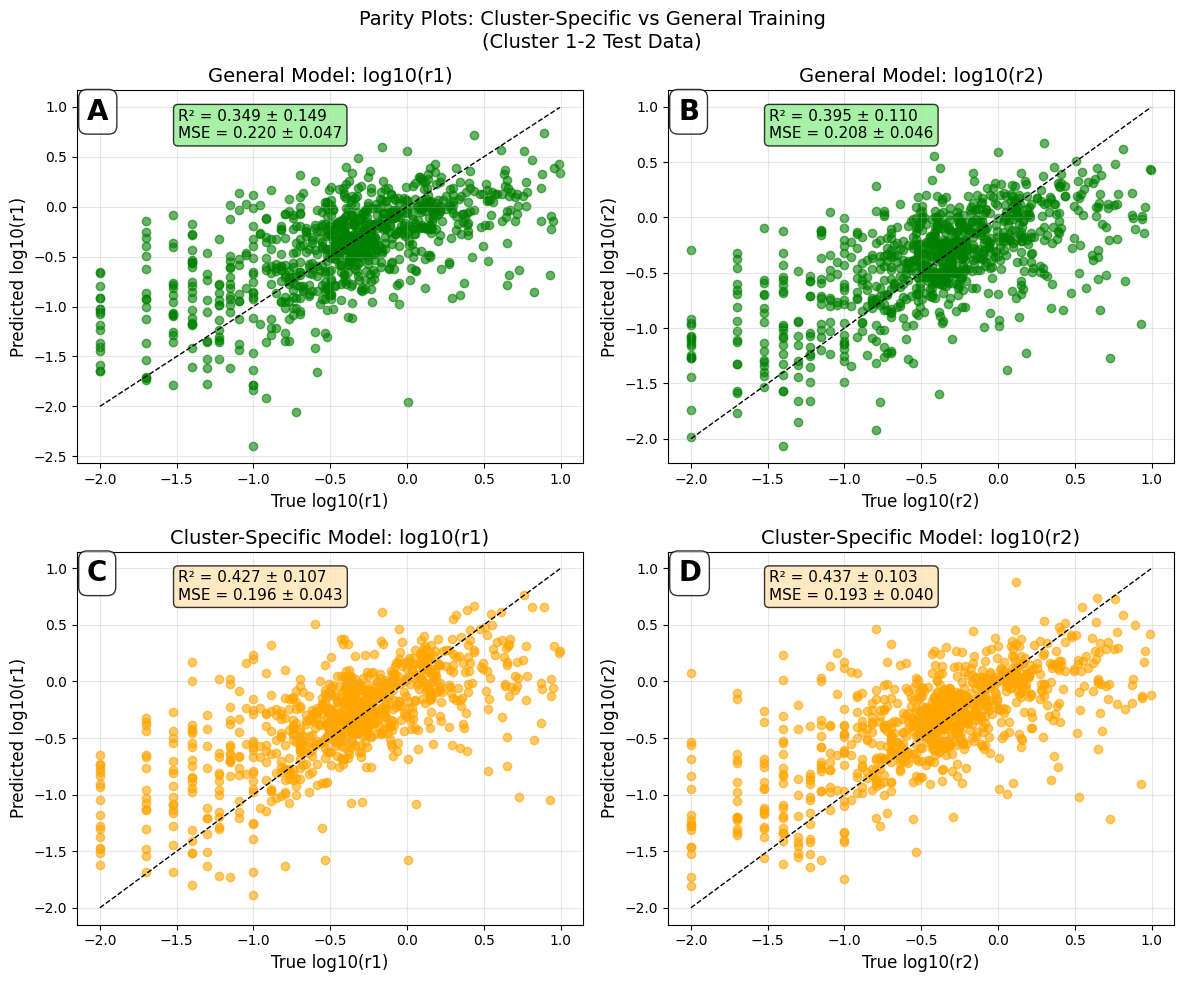


Experiment completed successfully!
Total test samples across all folds: 858

Summary Statistics (Mean ± SD across 10 folds):
General Model:
  R² r1: 0.349 ± 0.149
  R² r2: 0.395 ± 0.110
  MSE r1: 0.220 ± 0.047
  MSE r2: 0.208 ± 0.046

Cluster-Specific Model:
  R² r1: 0.427 ± 0.107
  R² r2: 0.437 ± 0.103
  MSE r1: 0.196 ± 0.043
  MSE r2: 0.193 ± 0.040


In [5]:
"""
Controlled Experiment: Cluster 1–2 vs. General Training (Morgan-only)
--------------------------------------------------------------------
Goal:
  For predicting reactivity ratios (r1, r2) on a specific interaction (Cluster 1–2),
  test whether training:
    (A) on the *same* interaction subset (cluster-specific), or
    (B) on a *random* subset of the entire dataset of equal size (general)
  yields better performance.

Design:
  • Inputs: Morgan fingerprints only (concatenate A and B).
  • Targets: log10(r1), log10(r2).
  • 10-fold CV over *Cluster 1–2* samples:
      - Each fold's test set is fixed (Cluster 1–2 only).
      - Cluster-specific TRAIN = the remaining Cluster 1–2 samples in that fold.
      - General TRAIN = random subset from the whole dataset (same size as cluster train), excluding this fold's test rows.
  • Compare R² and MSE on the identical Cluster 1–2 test sets.

Why this is fair:
  Both models see the *exact same* number of training samples in each fold,
  and are evaluated on the *exact same* test items (Cluster 1–2).
"""

# =========================
# Imports & Config
# =========================
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt

# ---- Reproducibility (important for fair comparisons) ----
np.random.seed(42)
tf.random.set_seed(42)

# ---- Morgan fingerprint hyperparameters ----
MORGAN_RADIUS = 3
MORGAN_BITS   = 2048  # per monomer (A and B -> 4096 total features)

# ---- DNN hyperparameters (kept simple & consistent) ----
NEURONS_L1       = 80
NEURONS_L2       = 40
LEARNING_RATE    = 1e-3
BATCH_SIZE       = 32
MAX_EPOCHS       = 200
VALIDATION_SPLIT = 0.10
PATIENCE         = 30

# ---- Visualization look (optional) ----
plt.rcParams.update({'font.size': 12})

# =========================
# Helper functions
# =========================
def get_morgan_fp(smiles: str) -> np.ndarray:
    """
    Convert a SMILES string into a Morgan fingerprint bit vector (as float32).
    Returns an all-zero vector if SMILES cannot be parsed.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(MORGAN_BITS, dtype=np.float32)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
            mol, MORGAN_RADIUS, nBits=MORGAN_BITS
        )
        return np.array(fp, dtype=np.float32)
    except Exception:
        return np.zeros(MORGAN_BITS, dtype=np.float32)

def build_model(n_inputs: int) -> tf.keras.Model:
    """
    Simple 2-hidden-layer DNN predicting [log10(r1), log10(r2)].
    Matches your previous architecture spirit and keeps capacity modest.
    """
    model = Sequential([
        Dense(NEURONS_L1, activation='relu', input_shape=(n_inputs,)),
        Dense(NEURONS_L2, activation='relu'),
        Dense(2, activation='linear')  # outputs: [log10(r1), log10(r2)]
    ])
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    return model

def metrics_dict(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """
    Convenience wrapper: compute R² and MSE for both outputs.
    y_* are shaped (n, 2) on log10 scale.
    """
    return {
        'r2_r1':  r2_score(y_true[:, 0], y_pred[:, 0]),
        'r2_r2':  r2_score(y_true[:, 1], y_pred[:, 1]),
        'mse_r1': mean_squared_error(y_true[:, 0], y_pred[:, 0]),
        'mse_r2': mean_squared_error(y_true[:, 1], y_pred[:, 1]),
    }

def extract_Xy(df_subset: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """
    Build Morgan-only features for a dataframe subset and grab targets.
    Feature = [Morgan(SMILES_A) || Morgan(SMILES_B)]  -> shape = (n, 4096)
    Target  = [log10(r1), log10(r2)]                 -> shape = (n, 2)
    """
    fpA = np.array([get_morgan_fp(s) for s in df_subset['SMILES_A']])
    fpB = np.array([get_morgan_fp(s) for s in df_subset['SMILES_B']])
    X   = np.concatenate([fpA, fpB], axis=1)
    y   = df_subset[['r1_log', 'r2_log']].values.astype(np.float32)
    return X, y

# =========================
# Data preparation
# =========================
# Expect: df exists with required columns. Copy & basic quality filters.
data = df.copy()

# Filter: valid positive ratios; drop rows missing SMILES
data = data[(data['r1'] > 0) & (data['r2'] > 0)].dropna(subset=['SMILES_A', 'SMILES_B'])

# Targets on log scale (symmetric error treatment for ratios)
data['r1_log'] = np.log10(data['r1'])
data['r2_log'] = np.log10(data['r2'])

print(f"Dataset after QC: {len(data)} rows")

# =========================
# Select Cluster 1–2 interaction rows
# =========================
# For 1–2, one monomer belongs to Cluster 1, the other to Cluster 2.
# This includes both (1,2) and (2,1) orderings since they represent the same interaction type.
mask_12 = ((data['Cluster_A'] == 1) & (data['Cluster_B'] == 2)) | \
          ((data['Cluster_A'] == 2) & (data['Cluster_B'] == 1))
cluster12_idx = data.index[mask_12].to_numpy()
print(f"Cluster 1–2 samples: {len(cluster12_idx)}")

if len(cluster12_idx) < 100:
    raise ValueError("Not enough Cluster 1–2 samples for 10-fold CV. Need at least ~100.")

# Precompute features for the *entire* dataset once (saves time)
X_all, y_all = extract_Xy(data)

# Quick index mapping utility: map dataframe indices to row positions
# (so we can slice X_all / y_all quickly).
pos_map = {idx: pos for pos, idx in enumerate(data.index)}

# =========================
# 10-fold CV over Cluster 1–2 indices
# =========================
kf = KFold(n_splits=10, shuffle=True, random_state=42)

results = {
    'general': [],  # metrics per fold for general model
    'cluster': []   # metrics per fold for cluster-specific model
}

# Store all predictions for parity plots
all_y_true = []
all_y_pred_general = []
all_y_pred_cluster = []

print("\nStarting 10-fold CV on Cluster 1–2...")
for fold, (train_ids_pos, test_ids_pos) in enumerate(kf.split(cluster12_idx), start=1):
    # 1) Identify actual df indices for this fold's cluster train/test
    cluster_train_ids = cluster12_idx[train_ids_pos]
    cluster_test_ids  = cluster12_idx[test_ids_pos]

    # 2) Build the *fixed* test set (Cluster 1–2 only)
    test_positions = [pos_map[i] for i in cluster_test_ids]
    X_test = X_all[test_positions]
    y_test = y_all[test_positions]

    # 3) Cluster-specific training set (Cluster 1–2 only)
    cluster_train_positions = [pos_map[i] for i in cluster_train_ids]
    X_cluster_tr = X_all[cluster_train_positions]
    y_cluster_tr = y_all[cluster_train_positions]

    # 4) General training set: random sample of the same size from ALL data,
    #    ensuring we DO NOT "peek" at this fold's test rows.
    #    (We exclude the fold's test indices from the sampling pool.)
    available_pool = data.index.difference(cluster_test_ids).to_numpy()
    n_train = len(cluster_train_ids)  # enforce identical training size

    if len(available_pool) < n_train:
        raise ValueError(f"Fold {fold}: not enough available rows for general sampling.")

    # Use different random seed base for cluster 1-2 experiment to ensure independence
    rng = np.random.default_rng(142 + fold)  # per-fold reproducibility
    general_train_ids = rng.choice(available_pool, size=n_train, replace=False)
    general_train_positions = [pos_map[i] for i in general_train_ids]
    X_general_tr = X_all[general_train_positions]
    y_general_tr = y_all[general_train_positions]

    # 5) Train both models with identical settings
    def train_and_eval(Xtr, ytr, model_type):
        tf.keras.backend.clear_session()
        model = build_model(Xtr.shape[1])
        es = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                           restore_best_weights=True, verbose=0)
        model.fit(
            Xtr, ytr,
            epochs=MAX_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=VALIDATION_SPLIT,
            callbacks=[es],
            verbose=0
        )
        yhat = model.predict(X_test, verbose=0)
        return metrics_dict(y_test, yhat), yhat

    general_metrics, y_pred_general = train_and_eval(X_general_tr, y_general_tr, 'general')
    cluster_metrics, y_pred_cluster = train_and_eval(X_cluster_tr, y_cluster_tr, 'cluster')

    results['general'].append(general_metrics)
    results['cluster'].append(cluster_metrics)
    
    # Store predictions for parity plots
    all_y_true.append(y_test)
    all_y_pred_general.append(y_pred_general)
    all_y_pred_cluster.append(y_pred_cluster)

    # Short fold summary
    print(
        f"Fold {fold:02d} | n_train={n_train:4d} | "
        f"General R²: r1={general_metrics['r2_r1']:.3f}, r2={general_metrics['r2_r2']:.3f} | "
        f"Cluster R²: r1={cluster_metrics['r2_r1']:.3f}, r2={cluster_metrics['r2_r2']:.3f}"
    )

# =========================
# Aggregate & report
# =========================
def summarize(label, records):
    r2r1 = np.array([r['r2_r1']  for r in records])
    r2r2 = np.array([r['r2_r2']  for r in records])
    mser1= np.array([r['mse_r1'] for r in records])
    mser2= np.array([r['mse_r2'] for r in records])
    print(f"\n{label} (10-fold CV):")
    print(f"  R² r1: {r2r1.mean():.3f} ± {r2r1.std():.3f}")
    print(f"  R² r2: {r2r2.mean():.3f} ± {r2r2.std():.3f}")
    print(f"  MSE r1: {mser1.mean():.3f} ± {mser1.std():.3f}")
    print(f"  MSE r2: {mser2.mean():.3f} ± {mser2.std():.3f}")

summarize("GENERAL model", results['general'])
summarize("CLUSTER-SPECIFIC (1–2) model", results['cluster'])

# =========================
# Calculate fold-wise metrics for mean ± SD display
# =========================

# Extract fold-wise metrics
general_r2_r1 = np.array([r['r2_r1'] for r in results['general']])
general_r2_r2 = np.array([r['r2_r2'] for r in results['general']])
general_mse_r1 = np.array([r['mse_r1'] for r in results['general']])
general_mse_r2 = np.array([r['mse_r2'] for r in results['general']])

cluster_r2_r1 = np.array([r['r2_r1'] for r in results['cluster']])
cluster_r2_r2 = np.array([r['r2_r2'] for r in results['cluster']])
cluster_mse_r1 = np.array([r['mse_r1'] for r in results['cluster']])
cluster_mse_r2 = np.array([r['mse_r2'] for r in results['cluster']])

# =========================
# Parity plots with mean ± SD metrics
# =========================
# Concatenate all predictions across folds (for plotting points)
y_true_all = np.vstack(all_y_true)
y_pred_general_all = np.vstack(all_y_pred_general)
y_pred_cluster_all = np.vstack(all_y_pred_cluster)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Parity Plots: Cluster-Specific vs General Training\n(Cluster 1-2 Test Data)', fontsize=14)

# General model plots
axes[0,0].scatter(y_true_all[:,0], y_pred_general_all[:,0], alpha=0.6, color='green')
mn, mx = y_true_all[:,0].min(), y_true_all[:,0].max()
axes[0,0].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[0,0].set_title('General Model: log10(r1)')
axes[0,0].set_xlabel('True log10(r1)')
axes[0,0].set_ylabel('Predicted log10(r1)')
axes[0,0].grid(alpha=0.3)
# Add performance metrics with mean ± SD format
axes[0,0].text(0.20, 0.95, f'R² = {general_r2_r1.mean():.3f} ± {general_r2_r1.std():.3f}\nMSE = {general_mse_r1.mean():.3f} ± {general_mse_r1.std():.3f}', 
               transform=axes[0,0].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
# Add panel label A
axes[0,0].text(0.02, 0.98, 'A', transform=axes[0,0].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

axes[0,1].scatter(y_true_all[:,1], y_pred_general_all[:,1], alpha=0.6, color='green')
mn, mx = y_true_all[:,1].min(), y_true_all[:,1].max()
axes[0,1].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[0,1].set_title('General Model: log10(r2)')
axes[0,1].set_xlabel('True log10(r2)')
axes[0,1].set_ylabel('Predicted log10(r2)')
axes[0,1].grid(alpha=0.3)
# Add performance metrics with mean ± SD format
axes[0,1].text(0.20, 0.95, f'R² = {general_r2_r2.mean():.3f} ± {general_r2_r2.std():.3f}\nMSE = {general_mse_r2.mean():.3f} ± {general_mse_r2.std():.3f}', 
               transform=axes[0,1].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
# Add panel label B
axes[0,1].text(0.02, 0.98, 'B', transform=axes[0,1].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

# Cluster-specific model plots
axes[1,0].scatter(y_true_all[:,0], y_pred_cluster_all[:,0], alpha=0.6, color='orange')
mn, mx = y_true_all[:,0].min(), y_true_all[:,0].max()
axes[1,0].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[1,0].set_title('Cluster-Specific Model: log10(r1)')
axes[1,0].set_xlabel('True log10(r1)')
axes[1,0].set_ylabel('Predicted log10(r1)')
axes[1,0].grid(alpha=0.3)
# Add performance metrics with mean ± SD format
axes[1,0].text(0.20, 0.95, f'R² = {cluster_r2_r1.mean():.3f} ± {cluster_r2_r1.std():.3f}\nMSE = {cluster_mse_r1.mean():.3f} ± {cluster_mse_r1.std():.3f}', 
               transform=axes[1,0].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='moccasin', alpha=0.8))
# Add panel label C
axes[1,0].text(0.02, 0.98, 'C', transform=axes[1,0].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

axes[1,1].scatter(y_true_all[:,1], y_pred_cluster_all[:,1], alpha=0.6, color='orange')
mn, mx = y_true_all[:,1].min(), y_true_all[:,1].max()
axes[1,1].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[1,1].set_title('Cluster-Specific Model: log10(r2)')
axes[1,1].set_xlabel('True log10(r2)')
axes[1,1].set_ylabel('Predicted log10(r2)')
axes[1,1].grid(alpha=0.3)
# Add performance metrics with mean ± SD format
axes[1,1].text(0.20, 0.95, f'R² = {cluster_r2_r2.mean():.3f} ± {cluster_r2_r2.std():.3f}\nMSE = {cluster_mse_r2.mean():.3f} ± {cluster_mse_r2.std():.3f}', 
               transform=axes[1,1].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='moccasin', alpha=0.8))
# Add panel label D
axes[1,1].text(0.02, 0.98, 'D', transform=axes[1,1].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

plt.tight_layout()
plt.savefig('ClusterSpecific1-2.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nExperiment completed successfully!")
print(f"Total test samples across all folds: {len(y_true_all)}")

# Also print the summary statistics
print(f"\nSummary Statistics (Mean ± SD across 10 folds):")
print(f"General Model:")
print(f"  R² r1: {general_r2_r1.mean():.3f} ± {general_r2_r1.std():.3f}")
print(f"  R² r2: {general_r2_r2.mean():.3f} ± {general_r2_r2.std():.3f}")
print(f"  MSE r1: {general_mse_r1.mean():.3f} ± {general_mse_r1.std():.3f}")
print(f"  MSE r2: {general_mse_r2.mean():.3f} ± {general_mse_r2.std():.3f}")

print(f"\nCluster-Specific Model:")
print(f"  R² r1: {cluster_r2_r1.mean():.3f} ± {cluster_r2_r1.std():.3f}")
print(f"  R² r2: {cluster_r2_r2.mean():.3f} ± {cluster_r2_r2.std():.3f}")
print(f"  MSE r1: {cluster_mse_r1.mean():.3f} ± {cluster_mse_r1.std():.3f}")
print(f"  MSE r2: {cluster_mse_r2.mean():.3f} ± {cluster_mse_r2.std():.3f}")